<a href="https://colab.research.google.com/github/PingPingE/Learn_ML_DL/blob/main/Practice/Hands_On_ML/ch15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

# RNN과 CNN을 사용해 시퀀스 처리하기
- RNN은 순차 데이터를 다룬다.
- 하지만 순차 데이터를 디루는 유일한 신경망은 아니다.
  - 짧은 시퀀스: Dense 네트워크가 처리 가능
  - 긴 시퀀스: Conv 네트워크가 처리 가능

## 순한 뉴런과 순환 층
<img src="https://media.vlpt.us/images/changdaeoh/post/3afed92b-978e-4173-bc56-d8453c7f2b8f/image.png"/>

- RNN은 피드포워드 신경망과 매우 비슷하지만, 
- <strong>뒷쪽</strong>으로 순환하는 연결도 있다는 점이 다르다.
- 위 처럼 <strong>각 타임  스텝 t(또는 frame)마다 x_(t)와 이전 타임 스텝의 출력인 y_(t-1)를 입력</strong>으로 받는다.
  - 첫 번째 타임 스텝은 이전 출력이 없으므로 일반적으로 0으로 설정
  - 각 뉴런은 <strong>가중치도 두 개</strong>를 가진다.(하나는 x_(t), 다른 하나는 y_(t-1)를 위한 것)
  <img src="https://media.vlpt.us/images/changdaeoh/post/355c3d96-9e65-48fd-9ad6-6b2ba9f116b3/image.png" width= 50%  height=50%/>
  - 즉, Y_(t)는 시간 t=0에서부터 모든 입력에 대한 함수가 된다.
- 동일한 뉴런을 타임 스텝마다 하나씩 표현한 위 이미지를, '시간에 따라 네트워크를 펄쳤다'고 말한다.

  => 재귀를 펼쳐놓은 것으로 생각


## 메모리 셀
- 타임 스텝 t에서 순환 뉴런의 출력은 이전 타임 스텝의 모든 입력에 대한 함수이므로, 이를 일종의 <strong>메모리</strong> 형태라고 말할 수 있다.
- <strong>메모리 셀:</strong> 타임 스텝에 걸쳐서 <strong>어떤 상태를 보존</strong>하는 신경망의 구성 요소
- 각 스텝 t에서 셀의 상태 h_(t)는 (h: hidden) 그 타임 스텝의 입력과 이전 타임 스텝의 상태에 대한 함수이다.

<br>

  <img src="https://media.vlpt.us/images/changdaeoh/post/797fafe5-5df8-424e-8adc-fe654afbb43c/image.png"/>
 

## 입력과 출력 시퀀스
- <strong>벡터-투-시퀀스</strong>
  - 각 타임 스텝에서 하나의 입력 벡터를 반복해서 주입하고, 하나의 시퀀스 출력
  - ex) 이미지 주입 -> 이미지 캡션 출력

- <strong>시퀀스-투-벡터</strong>
  - 입력 시퀀스를 주입하고 마지막을 제외한 모든 출력을 무시
  - ex) 영화 리뷰에 있는 연속된 단어를 주입 -> 감성 점수 출력(싫다(-1)~좋다(+1))

- <strong>시퀀스-투-시퀀스</strong>
  - 입력 시퀀스를 받아 출력 시퀀스를 만든다.
  - ex) 최근 N일치의 주식가격 주입 -> 각 입력값보다 하루 앞선 가격 출력
  - (즉, N-1일 전부터 내일까지)

- <strong>인코더-디코더</strong>
   - 시퀀스-투-벡터 네트워크(인코더) 뒤에 벡터-투-시퀀스 네트워크(디코더) 연결
   - ex) 한 언어의 문장을 다른 언어로 번역
   - 인코더: 해당 문장을 하나의 벡터로 변환
   - 디코더: 해당 벡터를 다른 언어의 문장으로 디코딩
   - 왜 굳이 이중  모델? 
    - 하나의 시퀀스-투-시퀀스 네트워크보다 성능이 좋다.
    - <strong>번역하기 전에 전체 문장이 주입될 때까지 기다려야 하기 때문</strong>

<br>

<img src="https://img1.daumcdn.net/thumb/R720x0.q80/?scode=mtistory2&fname=http%3A%2F%2Fcfile22.uf.tistory.com%2Fimage%2F99A94F465BD1990B20352F"/>

## RNN 훈련하기
- BPTT(Backpropagation Through Time)
<img src="https://media.vlpt.us/images/changdaeoh/post/333a8501-57cb-4bc6-8e11-4ca2172b4286/image.png" width=50% height=50%/>

  - 타임 스텝으로 네트워크를 펼치고(실제로 펼치진 않음)
  - 보통의 역전파를 사용하는 것
    - 정방향 패스 동안에는 <strong>모두 동일한 가중치</strong>가 적용된다(즉, 같은 매개변수 W,b사용)
    - 그래서 역전파가 진행되면 <strong>모든 타임 스텝에 걸쳐 합산</strong>될 것이다.

## 시계열 예측하기
- 시계열: 타임 스텝마다 하나 이상의 값을 가진 시퀀스
  - 단변량 시계열: 하나의 값을 가지는 시퀀스(ex) 시간당 접속 사용자 수 예측)
  - 다변량 시계열: 여러 값을 가지는 시퀀스(ex) 기업의 분기별 재정 안정성 예측 -> 수입/부채 등 고려)
  - 보통 [배치 크기, 타임 스텝 수, 차원 수] 3D배열로 나타냄(단변량은 차원 수가 1)
  <img src="https://wikidocs.net/images/page/22886/rnn_image6between7.PNG"/>
- 시계열 예측으로 값 대체도 가능
  - 누락된 값 예측

In [1]:
def generate_time_series(batch_size, n_steps): #====batch_size만큼 n_steps 길이의 여러 시계열 생성
  freq1, freq2, offset1, offset2 = np.random.rand(4, batch_size, 1)
  time= np.linspace(0,1,n_steps) #n_steps개의 0~1사이의 값을 가지는 1d배열 생성
  series=0.5*np.sin((time-offset1)*(freq1*10+10))
  series +=0.2*np.sin((time-offset2)*(freq1*20+20))
  series +=0.1*(np.random.rand(batch_size, n_steps)-0.5) #잡음
  return series[..., np.newaxis].astype(np.float32)

In [22]:
n_steps= 50
series=generate_time_series(10000, n_steps+1)
X_train, y_train = series[:7000, :n_steps], series[:7000,-1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test=series[9000:, :n_steps], series[9000:,-1]

In [ ]:
series.shape

(10000, 51, 1)

In [ ]:
print(X_train.shape, y_train.shape)

(7000, 50, 1) (7000, 1)


---------------
시계열마다 1개의 값 예측

### 기준 성능
- 가장 간단한 방법: 각 시계열의 마지막 값을 그대로 예측 -> 순진한 예측이라고 함


In [4]:
y_pred=X_valid[:,-1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020505253

- 완전 연결 네트워크를 사용하는 방법

In [ ]:
model1 = keras.models.Sequential([
                                 keras.layers.Flatten(input_shape=[50,1]),
                                 keras.layers.Dense(1)
])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1.compile(optimizer='adam', loss='mse')
model1.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2090 - val_loss: 0.0619
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0517 - val_loss: 0.0343
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0296 - val_loss: 0.0208
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0175 - val_loss: 0.0139
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0127 - val_loss: 0.0107
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0090
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0060

-----------
val_loss: 0.0040까지 떨어짐

### 간단한 RNN 구현

In [ ]:
model2= keras.models.Sequential(
                                   keras.layers.SimpleRNN(1, input_shape=[None, 1])) #기본적으로 tanh 활성화 함수를 사용함

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.compile(optimizer='adam', loss='mse')
model2.fit(X_train, y_train,validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 3s 8ms/step - loss: 0.2255 - val_loss: 0.1936
Epoch 2/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1848 - val_loss: 0.1624
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1564 - val_loss: 0.1382
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1330 - val_loss: 0.1150
Epoch 5/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1085 - val_loss: 0.0927
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0879 - val_loss: 0.0733
Epoch 7/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0675 - val_loss: 0.0569
Epoch 8/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0513 - val_loss: 0.0430
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0390 - val_loss: 0.0320
Epoch 10/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0291 - val_loss: 0.0238

--------
val_loss가 0.0119로, 위 간단한 선형 모델인 model1(0.004)보다 좋지 못한 성능이지만, <br>
파라미터가 3개로, 51개인 위 모델보다 훨씬 적다.

### 심층 RNN
<img src="https://wikidocs.net/images/page/22886/rnn_image8_ver2.PNG"/>

- return_sequences=True로 설정함으로써 시퀀스-투-시퀀스 문제를 풀 수 있다.
  - 기본으로 케라스의 순환 층은 최종 출력만 반환함
  - 타임 스텝마다 출력을 반환하려면 True로 지정해야함

In [ ]:
model3= keras.models.Sequential([
                                 keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20, return_sequences=True),
                                 keras.layers.SimpleRNN(1)
])

In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


------------
return_sequences=True로 바꾼 후 output shape가 3D가 되었다.

=> 현재 타임 스텝의 출력만 보는게 아니라 모든 타임 스텝의 출력을 담았기 때문 

In [ ]:
model3.compile(optimizer='adam', loss='mse' )
model3.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 9s 29ms/step - loss: 0.0330 - val_loss: 0.0039
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 7/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 8/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 9/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 10/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0026 - val_lo

-------------------
- 최저 0.0019로, model1(0.004)보다 좋은 성능을 보인다.
- 하지만, 마지막 층을 굳이 SimpleRNN을 쓸 필요가 없다.
  - 마지막 층의 은닉 상태는 크게 필요하지 않다.
  - tanh 활성화 함수를 쓴다 -> 즉, -1~1사이의 값이 나온다.

#### 마지막 층 변경

In [8]:
model4= keras.models.Sequential([
                                 keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None, 1]),
                                 keras.layers.SimpleRNN(20),#=====출력층이 Dense로 바뀌었으니 해당 층이 RNN 마지막 층
                                 keras.layers.Dense(1)
])

In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.compile(optimizer='adam', loss='mse' )
model4.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0401 - val_loss: 0.0041
Epoch 2/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 3/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 6/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 7/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 8/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0024 - val_lo

----------------
- model3보다 빠르게 수렴(27(model3) -> 19ms)하고 성능(0.0019(model3) -> 0.0018)도 좋다
- 또한 출력층의 활성화 함수도 원하는 함수로 바꿀 수 있다.

#### 실험: activation function  바꿔보기
- model4에서 activation만 tanh -> relu로 변경

In [ ]:
model5= keras.models.Sequential([
                                 keras.layers.SimpleRNN(20,return_sequences=True, input_shape=[None, 1], activation='relu'),
                                 keras.layers.SimpleRNN(20, activation='relu'),
                                 keras.layers.Dense(1)
])

In [ ]:
model5.compile(optimizer='adam', loss='mse' )
model5.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0865 - val_loss: 0.0066
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0061 - val_loss: 0.0050
Epoch 3/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 6/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0037 - val_loss: 0.0041
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 9/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/20
219/219 [==============================] - 4s 19ms/step - loss: 0.0036 - val_lo

--------
<strong>왜 tanh -> relu로 바꾸니 성능이 안좋아졌을까?(애초에 왜 tanh가 디폴트지?)</strong>
- ex) 경사하강법이 <strong>첫 번째 타임 스텝에서 출력을 조금 증가시키는 방향으로 가중치를 업데이트</strong>한다고 가정
  - 동일한 가중치가 모든 타임 스텝에서 사용되므로 두 번째 타임 스텝의 출력도 조금 증가할 수 있고, 세 번째, 네 번째... <strong>N 번째도 마찬가지</strong>다.
  - 즉, 이런식으로 출력이 <strong>폭주</strong>할 수 있다.
  - 이런 상황에서 <strong>수렴하지 않는 relu함수</strong>를 사용한다면 이를 막지 못할 것이다.
    - 물론, learning rate를 낮게 해서 위험을 감소시킬 순 있음
  - 그래서 간단히 <strong>tanh같은 수렴하는 활성화 함수</strong>를 기본으로 사용하는 것


<br>

참고) 핸즈온 15.4.1: 불안정한 그레이디언트 문제와 싸우기

### 여러 타임 스텝 앞을 예측하기
- 다음 1 스텝이 아니라,다음 10 스텝의 값을 예측하고 싶다면?
  - 방법1: 이미 훈련된 모델을 사용하여 다음 값 예측 -> 인풋으로 넣기 -> 다음 값 예측 -> 인풋 ... -> 10번째 값 예측
  - 방법2: RNN을 훈련하여 다음 값 10개를 한 번에 예측

#### 방법1: 예측 -> 인풋 -> 예측 -> 인풋...  N번 반복
- N=10일 때

In [59]:
n_steps=50
series=generate_time_series(1,n_steps+10)
X_new, Y_new = series[:,:n_steps], series[:,n_steps:]
X=X_new
for step_ahead in range(10):
  y_pred_one = model4.predict(X[:,step_ahead:])[:,np.newaxis,:] #차원 맞춰 주고
  X=np.concatenate([X, y_pred_one],axis=1) #기존 인풋과 concat

Y_pred = X[:, n_steps:] #뒤에 10개 X로 Y_new예측

In [84]:
Y_new

array([[[ 0.17075415],
        [ 0.01138176],
        [-0.14949368],
        [-0.37321958],
        [-0.46031514],
        [-0.51971924],
        [-0.6094004 ],
        [-0.5567631 ],
        [-0.54792917],
        [-0.46920696]]], dtype=float32)

In [60]:
Y_pred

array([[[-0.26945555],
        [-0.33359936],
        [-0.29922998],
        [-0.50576895],
        [-0.6751923 ],
        [-0.5499312 ],
        [-0.8395269 ],
        [-0.5986985 ],
        [-0.2887066 ],
        [-0.56050885]]], dtype=float32)

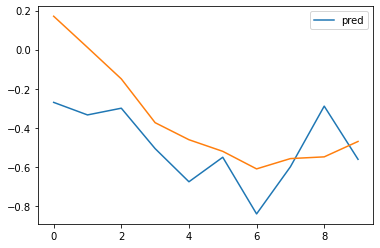

In [61]:
plt.plot(Y_pred.reshape(10,-1), label='pred')
plt.plot(Y_new.reshape(10,-1))
plt.legend()

---------
- 추세는 얼추... 맞은 것 같은데 

#### 방법2: RNN(시퀀스-투-벡터)

- N=10
- 시퀀스-투-벡터 모델이지만 1개가 아닌 10개의 값 출력

In [35]:
n_steps= 50
series=generate_time_series(10000, n_steps+10)
X_train, y_train = series[:7000, :n_steps], series[:7000,-10:,0]#===타깃 값 주목(끝에서 10개)
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:,0]
X_test, y_test=series[9000:, :n_steps], series[9000:,-10:,0]

In [36]:
model6=keras.models.Sequential([
                                keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
                                keras.layers.SimpleRNN(20),
                                keras.layers.Dense(10)
])

In [37]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [39]:
model6.compile(optimizer='adam', loss='mse')
model6.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20)

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.1107 - val_loss: 0.0330
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0296 - val_loss: 0.0202
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0186 - val_loss: 0.0149
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0149 - val_loss: 0.0122
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0127 - val_loss: 0.0100
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0107 - val_loss: 0.0088
Epoch 7/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0095 - val_loss: 0.0078
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0078 - val_loss: 0.0074
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 10/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0062 - val_lo

- 위 모델로 예측해보기

In [62]:
Y_pred2=model6.predict(X_new)
Y_pred2

array([[ 0.08488945, -0.11067114, -0.21381468, -0.36352   , -0.4209832 ,
        -0.45862257, -0.4869159 , -0.5279871 , -0.52525985, -0.52882004]],
      dtype=float32)

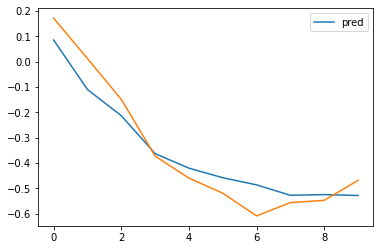

In [63]:
plt.plot(Y_pred2.reshape(10,-1), label='pred')
plt.plot(Y_new.reshape(10,-1))
plt.legend()

---------
방법1로 나온 Y_pred보다 훠어얼씬 실제 값과 가까움

=> 수치로 비교해보자

- MAE

In [91]:
keras.losses.mean_absolute_error(Y_pred.reshape(1,10),Y_new.reshape(1,10)) #====방법1

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.1935152], dtype=float32)>

In [92]:
keras.losses.mean_absolute_error(Y_pred2.reshape(1,10),Y_new.reshape(1,10))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.06159097], dtype=float32)>

- MSE

In [93]:
keras.losses.mean_squared_error(Y_pred.reshape(1,10),Y_new.reshape(1,10)) #====방법 1

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.0530121], dtype=float32)>

In [94]:
keras.losses.mean_squared_error(Y_pred2.reshape(1,10),Y_new.reshape(1,10))

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.00516789], dtype=float32)>

------------
- 방법 1은  0.19351521(MAE) , 0.0530121(MSE) 
- 방법 2는 0.06159097(MAE), 0.00516789(MSE)

=> 방법 2가 더  good

#### 방법 3: RNN(시퀀스-투-시퀀스)
- 마지막 스텝에서만 10개를 예측하는 위 모델 대신, 모든 타임 스텝에서 다음 값 10개를 예측하도록 훈련
- 장점?
  - 모든 타임 스텝에서 RNN출력에 대한 항이 손실에 포함된다는 것
  - 즉, 각 타임 스텝의 출력에서 gradient가 흐를 수 있다  => 안정적 + 훈련 속도 업
    - ex) 타임 스텝 0에서 타임 스텝 1~ 10까지 예측할 것이고, <br>
      타임 스텝 1에선 타임 스텝 2~11까지 예측할 것이고 ....